# Libraries

In [36]:
!pip install dwave-ocean-sdk

In [37]:
!pip install dwave-neal

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from collections import Counter

In [39]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import dwave.inspector as inspector
from dimod import ConstrainedQuadraticModel, CQM, SampleSet
from dwave.system import LeapHybridCQMSampler
from dimod.vartypes import Vartype
from dimod import Binary, quicksum
from dimod import BinaryQuadraticModel

In [40]:
from neal import SimulatedAnnealingSampler

# Utils

In [41]:
class KPInstance:
    def __init__(self, file_path="s000.kp"):
        self.file_path = file_path
        self.num_items = 0
        self.capacity = 0
        self.values = []
        self.weights = []
        self._read_instance()

    def _read_instance(self):
        with open(self.file_path, 'r') as f:
            # Strip whitespace and drop empty lines
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]

        # Read n and capacity
        self.num_items = int(lines[0])
        self.capacity = int(lines[1])

        # Next n lines: "value weight"
        item_lines = lines[2:]
        assert len(item_lines) == self.num_items, (
            f"Expected {self.num_items} items, got {len(item_lines)}"
        )

        vals, wts = [], []
        for line in item_lines:
            v_str, w_str = line.split()
            vals.append(int(v_str))
            wts.append(int(w_str))

        self.values = vals
        self.weights = wts

    def __str__(self):
        preview = list(zip(self.values, self.weights))[:5]
        return (f"KPInstance with {self.num_items} items\n"
                f"Capacity: {self.capacity}\n"
                f"First 5 items (value, weight): {preview}")

In [42]:
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))


def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

# Import data

In [43]:
knapsack = KPInstance(file_path="s_toy.kp")

In [44]:
print(knapsack)

KPInstance with 10 items
Capacity: 15
First 5 items (value, weight): [(8, 4), (3, 2), (7, 5), (2, 1), (9, 4)]


# Create the BQM

$$
\begin{array}{ll}
\text{maximize} & \displaystyle \sum_{i=1}^n v_i x_i \\[1.2em]
\text{subject to} & \displaystyle \sum_{i=1}^n w_i x_i \leq W \\[1.2em]
& x_i \in \{0,1\}, \quad i = 1,\dots,n
\end{array}
$$

In [45]:
N = range(len(knapsack.values))

In [46]:
bqm = BinaryQuadraticModel(Vartype.BINARY)

# Create Variables

In [47]:
x = np.array([f'x_{i}' for i in N])

# Create objective function

From:

$$
\max \quad \sum x_i \cdot v_i
$$

To:

$$
\min \quad \sum -x_i \cdot v_i
$$

In [48]:
Z_expr = []
for i in N:
    nameVar = x[i]
    Z_expr.append(f"{knapsack.values[i]}*{nameVar}")
    bqm.add_linear(nameVar,-1*knapsack.values[i])

In [49]:
pprint('Z = ' + ' + '.join(Z_expr))

('Z = 8*x_0 + 3*x_1 + 7*x_2 + 2*x_3 + 9*x_4 + 6*x_5 + 4*x_6 + 10*x_7 + 5*x_8 + '
 '1*x_9')


# Capacity Constraint

$$
\sum x_i \cdot w_i \leq W
$$

In [50]:
terms = [(x[i], knapsack.weights[i]) for i in N]

In [51]:
LAMBDA = 2*sum(knapsack.values)

In [52]:
bqm.add_linear_inequality_constraint(terms=terms,
                                      lagrange_multiplier = LAMBDA,
                                      label='capacity',
                                      constant = -knapsack.capacity)

[('slack_capacity_0', 1),
 ('slack_capacity_1', 2),
 ('slack_capacity_2', 4),
 ('slack_capacity_3', 8)]

In [53]:
Q = bqm.to_numpy_matrix(bqm.variables)

/tmp/ipython-input-3414522484.py:1: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0 and will be removed in 0.12.0
  Q = bqm.to_numpy_matrix(bqm.variables)


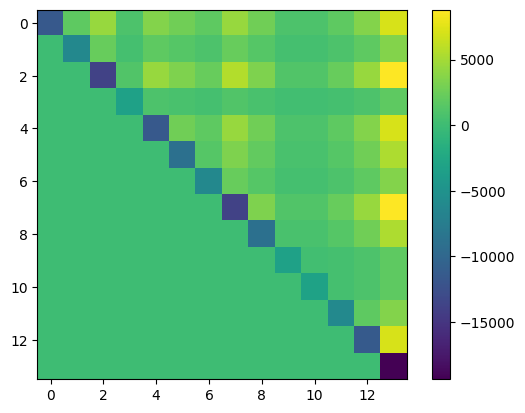

In [54]:
plt.imshow(Q)
plt.colorbar()
plt.show()

# Embedding

In [55]:
import minorminer
import dwave_networkx as dnx

In [56]:
G_problem = bqm.to_networkx_graph()

/tmp/ipython-input-152417704.py:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  G_problem = bqm.to_networkx_graph()


In [57]:
m = 4
G_target = dnx.pegasus_graph(m)
topology_type = 'pegasus'

In [58]:
embedding = minorminer.find_embedding(G_problem, G_target)

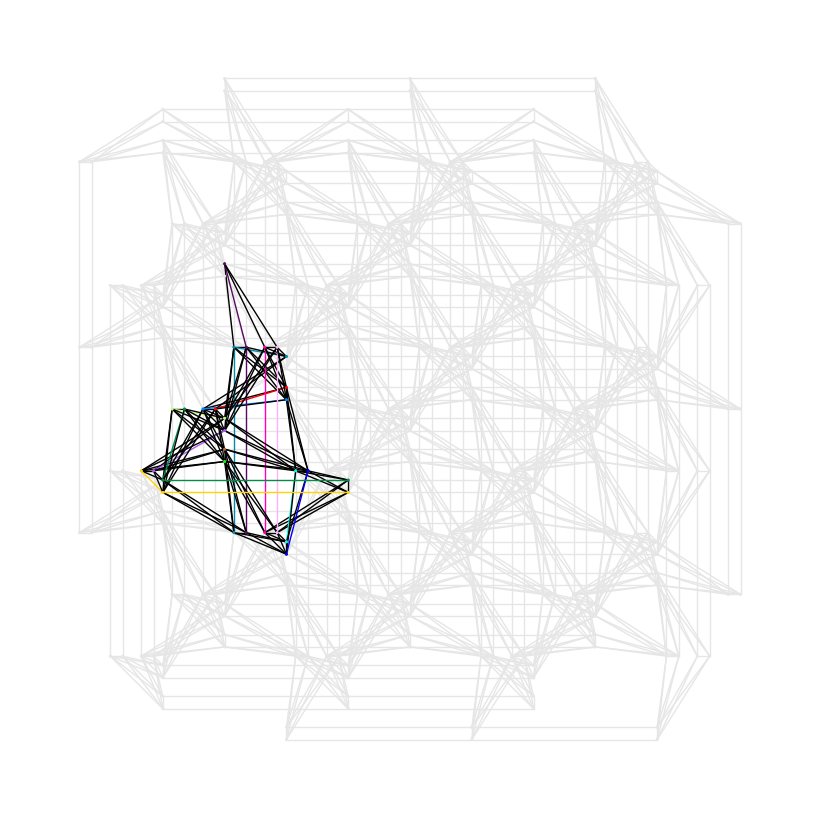

In [59]:
plt.figure(figsize=(8, 8))
dnx.draw_pegasus_embedding(G_target, embedding, show_labels=False, node_size=1)
plt.show()

In [60]:
m_zep = 2
G_zep = dnx.zephyr_graph(m_zep)
topology_type = 'Zephyr'

In [61]:
emb_zep = minorminer.find_embedding(G_problem, G_zep, random_seed=123)

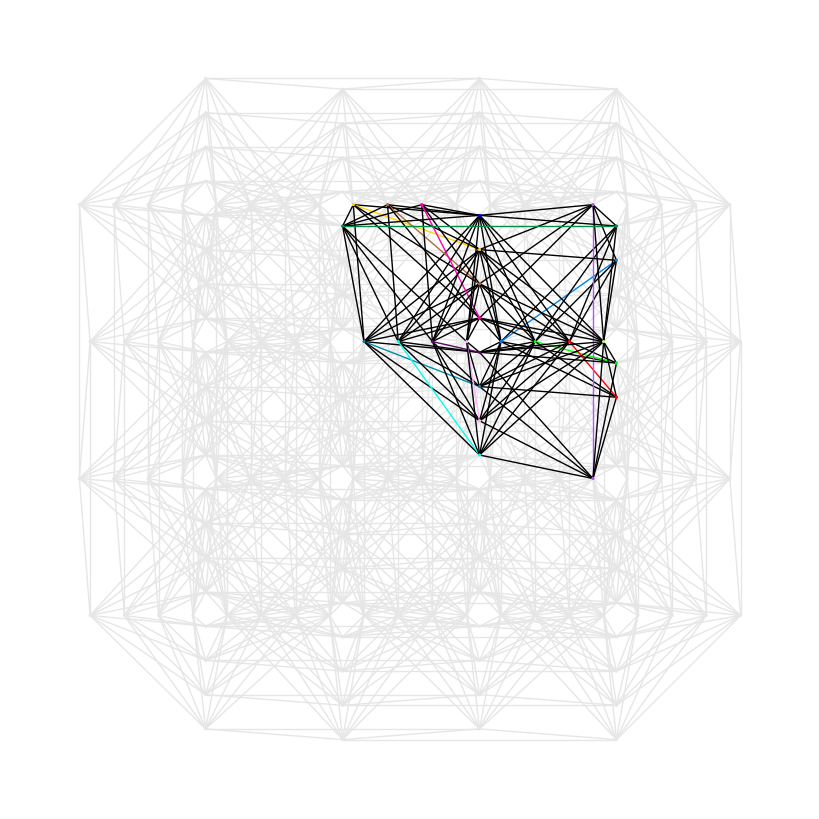

In [62]:
plt.figure(figsize=(8, 8))
dnx.draw_zephyr_embedding(G_zep,emb_zep,show_labels=False, node_size=1)
plt.show()

# Solve BQM

In [63]:
simAnnSampler = SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(bqm, num_reads=1000)

minimum energy: -31.0


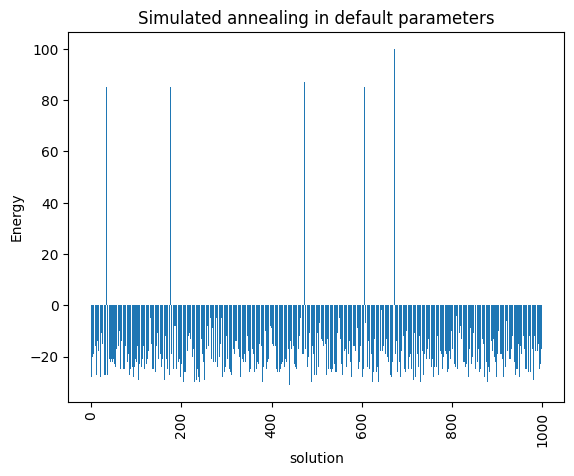

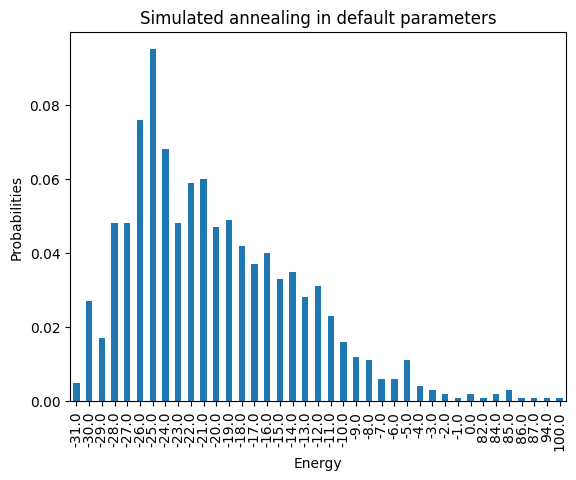

minimum energy: -31.0


In [64]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

In [75]:
simAnnSamples.record

rec.array([([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],  -6., 1),
           ([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0], -28., 1),
           ([0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], -23., 1),
           ([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0], -20., 1),
           ([1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], -24., 1),
           ([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0], -19., 1),
           ([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1], -17., 1),
           ([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0], -27., 1),
           ([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1], -25., 1),
           ([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1], -16., 1),
           ([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0], -16., 1),
           ([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1], -25., 1),
           ([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0], -27., 1),
           ([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1], -23., 1),
           ([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0], -14., 1),
          

In [65]:
best = simAnnSamples.first.sample

In [66]:
solution = [0]*knapsack.num_items

In [71]:
for k in best:
  if 'slack' in k:
    continue
  else:
    idx = int(k.split('_')[1])
    val = best[k]
    solution[idx] = int(val)

In [68]:
pprint(solution,width = 76,compact=True)

[0, 0, 0, 1, 1, 1, 1, 1, 0, 0]


In [69]:
weight_solution = sum([solution[i]*knapsack.weights[i] for i in range(len(solution))])
value_solution = sum([solution[i]*knapsack.values[i] for i in range(len(solution))])

In [70]:
print(f'Value of the Knapsack = {value_solution}')
print(f'Weight: {weight_solution}')
print(f'Capacity: {knapsack.capacity}')

Value of the Knapsack = 31
Weight: 15
Capacity: 15
